# This file contains image manipulation functions

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio.v2 as imageio

In [4]:
def show_image(img, title=None):
    """
        Display an image, using matplotlib.
        Handles grayscale and RGB
    """

    plt.figure(figsize=(8, 6))
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
def read_image(path):
    """
        Read an image from disk as RGB uint8
    """

    img = imageio.imread(path)
    if img.ndim == 2:
        return img #grayscale
    if img.shape[2] == 4:
        img = img[..., :3] #drop alpha
    return img.astype(np.uint8)

In [6]:
def save_image(path, img):
    """
        Saves an image to disk also ensures dtype is uint8 and values are valid
    """

    if img.dtype != np.uint8:
        imt = np.clip(imt, 0, 255).astype(np.uint8) #float scale -> uint8
    imageio.imwrite(path, img)

shape:  (460, 460, 3) dtype:  uint8


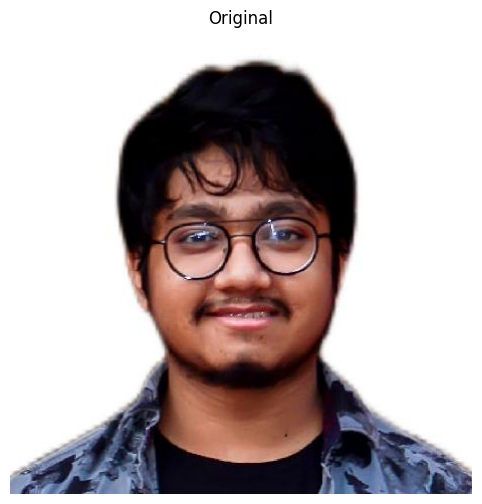

In [7]:
img = read_image('/home/arijit/Desktop/arijit.jpg')
print("shape: ", img.shape, "dtype: ", img.dtype)

show_image(img, 'Original')
str = "caption_here" 
save_image(f'/home/arijit/Desktop/{str}.jpg', img)

## Rotation 

## Image Rotation (Expert Notes)

### 1. Image Coordinate System

Images do **not** use the standard Cartesian coordinate system.

- Origin `(0, 0)` is at the **top-left**
- `x` increases to the **right**
- `y` increases **downward**

Pixel access in NumPy: img[y,x]


But geometric points are written as: (x, y)


This mismatch is important to remember.

---

## 2. Rotation in Mathematics (About the Origin)

A 2D rotation around the origin is defined as:

$$
R(\theta) =
\begin{bmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{bmatrix}
$$

For a point:

$$
\mathbf{p} =
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

The rotated point is:

$$
\mathbf{p'} = R(\theta)\mathbf{p}
$$

---

## 3. Why This Is Not Enough for Images

Images are **not centered at the origin**.

For an image of width `w` and height `h`:

$$
c_x = \frac{w}{2}, \quad c_y = \frac{h}{2}
$$

Rotation must happen around `(c_x, c_y)`.

---

## 4. Rotating Around an Arbitrary Point

To rotate around a center point:

1. Translate center to origin
2. Rotate
3. Translate back

This is mathematically required.

---

## 5. Combined Transformation

The full transform becomes:

$$
\begin{bmatrix}
x' \\
y'
\end{bmatrix}
=
R(\theta)
\begin{bmatrix}
x \\
y
\end{bmatrix}
+
\begin{bmatrix}
t_x \\
t_y
\end{bmatrix}
$$

Where:

$$
t_x = c_x - c_x\cos\theta + c_y\sin\theta
$$

$$
t_y = c_y - c_x\sin\theta - c_y\cos\theta
$$

---

## 6. OpenCV Affine Matrix

OpenCV uses a 2×3 affine matrix:

$$
M =
\begin{bmatrix}
a & b & t_x \\
c & d & t_y
\end{bmatrix}
$$

For rotation:

$$
M =
\begin{bmatrix}
\cos\theta & -\sin\theta & t_x \\
\sin\theta & \cos\theta & t_y
\end{bmatrix}
$$

---

## 7. `cv2.getRotationMatrix2D`

This function:

- Computes rotation terms
- Computes translation terms
- Packs everything into a single affine matrix

It represents:
**translate → rotate → translate**, combined.

---

## 8. `cv2.warpAffine`

- Applies the affine transform to every pixel
- Uses inverse mapping
- Uses interpolation to avoid holes

Cropping happens if the output canvas is too small.

---

## 9. Key Mental Model

Image rotation is:

- Coordinate transformation
- Plus resampling
- Plus interpolation

The math is always there, even if hidden by the API.




In [ ]:
def rotate(img, angle_deg, keep_size=False, border_value=0):
    """
    Rotate an image by angle_deg (degrees).
    
    keep_size=False: expands canvas so the whole rotated image fits (no cropping).
    keep_size=True: keeps original size (may crop).
    
    border_value: fill value for empty areas (0=black). For RGB, can be (0,0,0).
    """

    h, w = img.shape[:2]
    center = (w / 2, h / 2) # IMPORTANT: center is (x,y) = (w/2, h/2)

    # build the rotation matrix -> math behind rotation
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.5) # 1.5 => zoom factor

    # if user wants to keep the original size, i.e. keep_size = True, the image may crop (corners may go out of bounds)
    # cv2.warpAffine() applies the transform matrix M to the image
    if keep_size:
        return cv2.warpAffine(img, M, (w, h), borderValue=border_value)
    
    # expanded canvas, i.e. keep_size = False
    # first we need to extract cos and sin from the matrix to compute the new required width/height
    # M[0,0] stores cosθ and M[0,1] stores -sinθ. we will take abs() coz size must be positive

    cos = abs(M[0, 0])
    sin = abs(M[0, 1])

    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    # now we will move our rotated image to the center of bigger canvas through "move" part of M {t_x, t_y}

    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    # ✅ “We are telling OpenCV: rotate around the old center, but place the result in the center of the new bigger image.”

    return cv2.warpAffine(img, M, (new_w, new_h), borderValue=border_value)
    

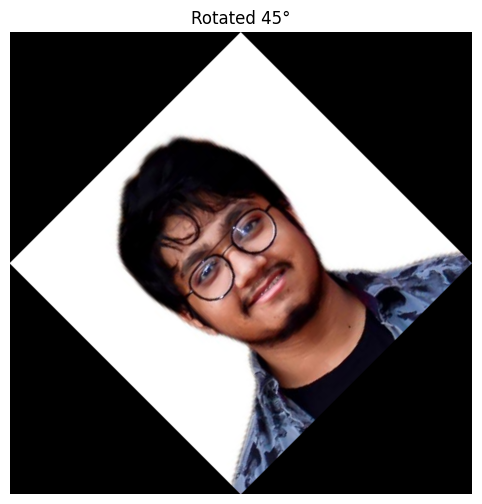

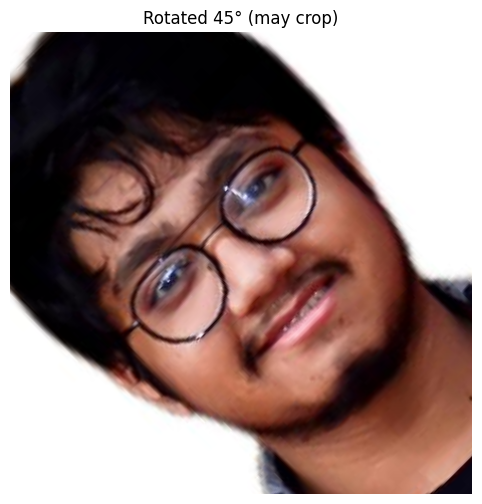

In [11]:
img_rot = rotate(img, 45, keep_size=False) #no cropping
show_image(img_rot, "Rotated 45°")
str = "rotated_no_crop"
save_image(f'/home/arijit/Desktop/{str}.jpg', img_rot)

img_rot_crop = rotate(img, 45, keep_size=True) #may crop
show_image(img_rot_crop, "Rotated 45° (may crop)")
str = "rotated_crop"
save_image(f'/home/arijit/Desktop/{str}.jpg', img_rot_crop)

# Image Resizing

## What is resizing?

Resizing means changing the **width** and **height** of an image.

Examples:
- 1024 × 1024 → 224 × 224 (very common in ML)
- 300 × 200 → 600 × 400

---

## Why resizing is important

Resizing is used because:
- ML models require **fixed-size inputs**
- Smaller images train **faster**
- Larger images keep **more detail**

Almost every image pipeline includes resizing.

---

## What happens during resizing?

- **Shrinking** an image:
  - Some pixels are removed
  - Fine details may be lost

- **Enlarging** an image:
  - New pixels are created
  - Image may look blurry or smooth

These new pixel values are created using **interpolation**.

---

## Aspect ratio (very important)

Aspect ratio = shape of the image.

Example:
- Original: 400 × 200
- Resized to: 400 × 400 → image looks **stretched**

Best practice:
- Keep the aspect ratio unless stretching is intentional

---

## Interpolation (simple meaning)

Interpolation decides **how pixel values are guessed** when resizing.

---

## Common interpolation types

### INTER_NEAREST
- Copies the closest pixel
- Fast but blocky
- Best for masks or labels

### INTER_LINEAR (default)
- Smooth averaging
- Good balance between speed and quality
- Best default choice

### INTER_AREA
- Best for shrinking images
- Reduces aliasing
- Recommended for downscaling

### INTER_CUBIC
- Smoother results
- Better for enlarging images
- Slower than linear

---

## Simple rule to remember

- Shrinking → `INTER_AREA`
- Enlarging → `INTER_CUBIC`
- Unsure → `INTER_LINEAR`
- Masks / labels → `INTER_NEAREST`

---

## Common mistakes

- Stretching images by breaking aspect ratio
- Using nearest interpolation for natural images
- Forgetting resizing before ML model input

---

## Key takeaway

Resizing changes image size,  
interpolation controls **how smooth or blocky** the result looks.

Resizing is a **basic but critical** step in image processing and ML.


In [1]:
def resize(img, width=None, height=None, keep_aspect=True, interpolation=None):
    """
    Resize an image.

    width, height: desired size
    keep_aspect=True: keeps image proportions
    interpolation can be:
    - Shrinking → `INTER_AREA`
    - Enlarging → `INTER_CUBIC`
    - Unsure → `INTER_LINEAR`
    - Masks / labels → `INTER_NEAREST`
    """

    h, w = img.shape[:2]

    if keep_aspect:
        #if only width is given
        if width is not None and height is None:
            scale = width / w
            height = int(h * scale)
        
        #if only height is given
        if width is None and height is not None:
            scale = height / h
            width = int(w * scale)

    return cv2.resize(img, (width, height), interpolation=interpolation)

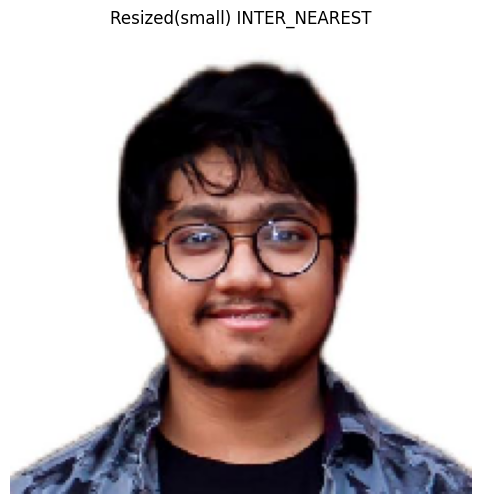

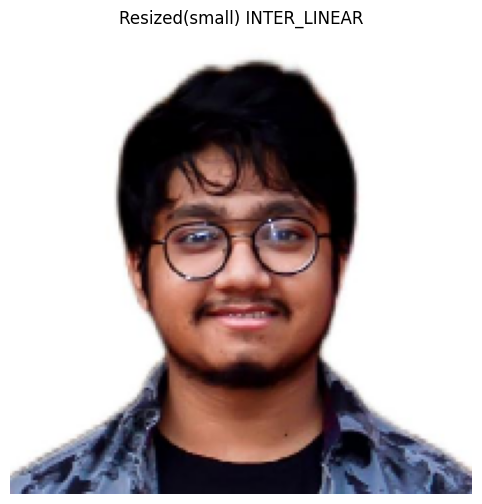

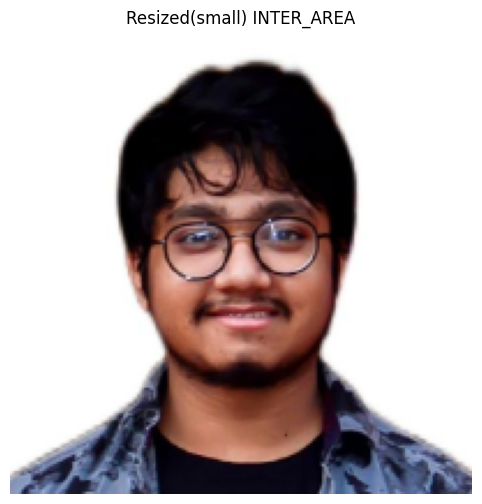

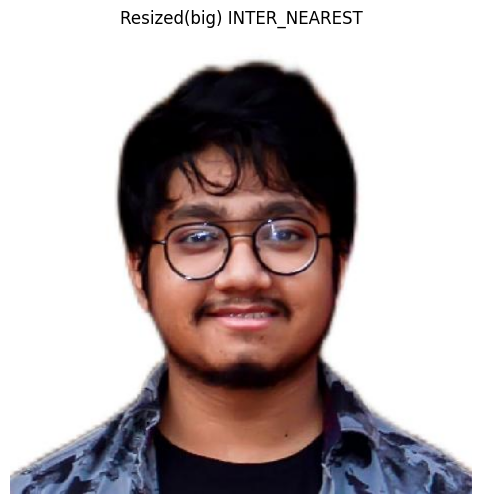

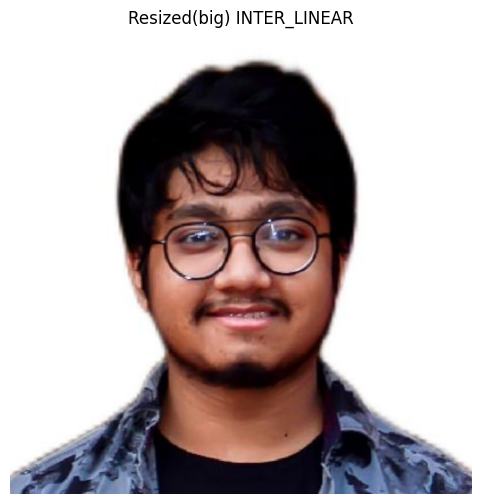

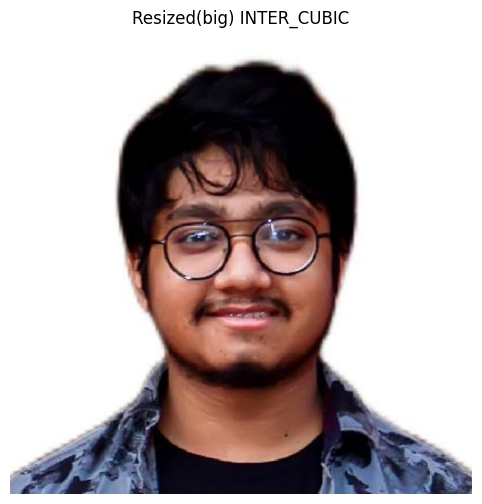

In [13]:
img_small_n = resize(img, width=200, interpolation=cv2.INTER_NEAREST)
show_image(img_small_n, "Resized(small) INTER_NEAREST")
save_image(f'/home/arijit/Desktop/small_n.jpg', img_small_n)
img_small_l = resize(img, width=200, interpolation=cv2.INTER_LINEAR)
show_image(img_small_l, "Resized(small) INTER_LINEAR")
save_image(f'/home/arijit/Desktop/small_l.jpg', img_small_l)
img_small_ar = resize(img, width=200, interpolation=cv2.INTER_AREA)
show_image(img_small_ar, "Resized(small) INTER_AREA")
save_image(f'/home/arijit/Desktop/small_ar.jpg', img_small_ar)

img_big_n = resize(img, width=800, interpolation=cv2.INTER_NEAREST)
show_image(img_big_n, "Resized(big) INTER_NEAREST")
save_image(f'/home/arijit/Desktop/big_n.jpg', img_big_n)
img_big_l = resize(img, width=800, interpolation=cv2.INTER_LINEAR)
show_image(img_big_l, "Resized(big) INTER_LINEAR")
save_image(f'/home/arijit/Desktop/big_l.jpg', img_big_l)
img_big_cu = resize(img, width=800, interpolation=cv2.INTER_CUBIC)
show_image(img_big_cu, "Resized(big) INTER_CUBIC")
save_image(f'/home/arijit/Desktop/big_cu.jpg', img_big_cu)

# Image Cropping (Beginner-Friendly Guide)

## What is cropping?

Cropping means **cutting out a rectangular part of an image**.

You:
- Keep the important region  
- Remove unnecessary background  

Cropping does **not** resize or distort pixels.

---

## Why cropping is important

Cropping is commonly used to:
- Focus on a region of interest (ROI)
- Remove useless background
- Improve ML model performance
- Prepare data for detection or classification

Examples:
- Face recognition → crop faces
- Object detection → crop bounding boxes
- Medical imaging → crop affected areas

---

## How cropping works (very important)

Cropping is done using **NumPy array slicing**.

### Image indexing rule
```python
img[y1:y2, x1:x2]


### Why?

- NumPy uses `img[row, column]`
- Row = `y`
- Column = `x`

⚠️ **Common mistake**

```python
img[x1:x2, y1:y2]  # ❌ wrong

## Coordinate system reminder

- Origin `(0, 0)` is at the **top-left**
- `x` increases to the right
- `y` increases downward

Coordinates mean:
- `(x1, y1)` → top-left corner
- `(x2, y2)` → bottom-right corner

---

## Simple crop function

```python
def crop(img, x1, y1, x2, y2):
    """
    Crop image using pixel coordinates.
    """
    return img[y1:y2, x1:x2]


## Center cropping (very common in ML)

Center cropping keeps the **middle part of the image**.

It is useful when:
- The important content is roughly centered
- You want a consistent crop without manual coordinates

---

### Center crop function

```python
def center_crop(img, crop_w, crop_h):
    h, w = img.shape[:2]

    x1 = (w - crop_w) // 2
    y1 = (h - crop_h) // 2

    x2 = x1 + crop_w
    y2 = y1 + crop_h

    return img[y1:y2, x1:x2]

### Used often before

- Resizing

- Feeding images into CNNs


---

### Cropping

What it does:
- Cuts out a rectangular region

How it works:
- NumPy slicing: img[y1:y2, x1:x2]

Why use it:
- Focus on important area
- Remove background

Key rule:
- Coordinates are (x, y)
- Indexing is [y, x]

Cropping does NOT:
- Change pixel values
- Use interpolation




In [16]:
def crop(img, x1, y1, x2, y2):
    """
    Crop image using pixel coordinates.
    
    (x1, y1): top-left corner
    (x2, y2): bottom-right corner
    """
    return img[y1:y2, x1:x2]

In [17]:
def center_crop(img, crop_w, crop_h):
    h, w = img.shape[:2]

    x1 = (w - crop_w) // 2
    y1 = (h - crop_h) // 2

    x2 = x1 + crop_w
    y2 = y1 + crop_h

    return img[y1:y2, x1:x2]

In [31]:
h, w = img.shape[:2]

img_crop = crop(
    img,
    x1 = w // 4,
    y1 = h // 4,
    x2 = 3 * w // 2,
    y2 = 3 * h // 2
)

save_image(f'/home/arijit/Desktop/normal_crop.jpg', img_crop)

img_crop_center = center_crop(
    img,
    crop_w = w // 2,
    crop_h = h // 2
)

save_image(f'/home/arijit/Desktop/center_crop.jpg', img_crop_center)



# Image Flip (Beginner-Friendly Guide)

## What is image flipping?

Image flipping means **reversing an image along an axis**.

It changes the image orientation but **does not change pixel values**.

---

## Why image flipping is important

Flipping is mainly used for **data augmentation** in ML.

Benefits:
- Increases dataset size
- Helps models generalize better
- Reduces overfitting

A flipped image is usually still a valid example of the same object.

---

## Types of image flip

There are two common types of flipping:

### Horizontal flip (left ↔ right)
- Also called **mirror flip**
- Most commonly used in ML

### Vertical flip (top ↔ bottom)
- Less common
- Used only when orientation does not matter

---

## Flip using OpenCV

OpenCV provides the `cv2.flip()` function.

```python
cv2.flip(img, flipCode)

```
| flipCode | Effect                |
| -------- | --------------------- |
| `1`      | Horizontal flip       |
| `0`      | Vertical flip         |
| `-1`     | Horizontal + Vertical |

## Important ML note (very important)

Flipping is **safe** only when orientation does not change meaning.

⚠️ **Be careful when flipping:**
- Text or numbers
- Traffic signs
- Medical images (left/right anatomy)
- Direction-sensitive objects

In these cases, flipping may produce **incorrect or misleading data**.

```
| Operation             | Flip      | Rotate         |
| --------------------- | --------  | ------------   |
| Uses interpolation    | ❌ No     | ✅ Yes         |
| Changes orientation   | ✅ Yes    | ✅ Yes         |
| Safe for augmentation | ✅ Mostly | ⚠️ Sometimes   |
| Computational cost    | Very low  | Higher         |



In [32]:
def flip_horizontal(img):
    return cv2.flip(img, 1)

def flip_vertical(img):
    return cv2.flip(img, 0)

def flip_both(img):
    return cv2.flip(img, -1)

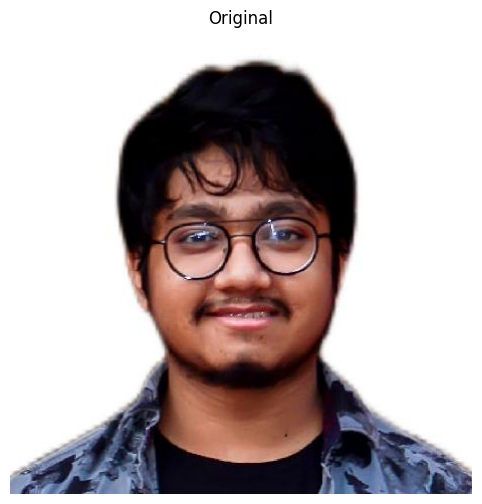

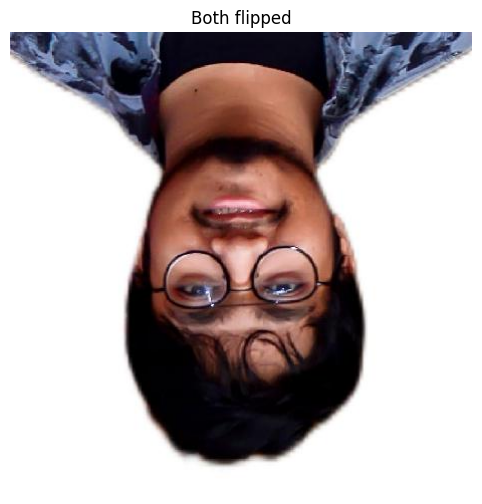

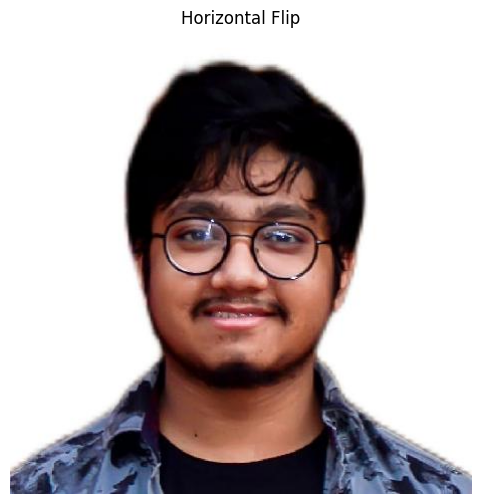

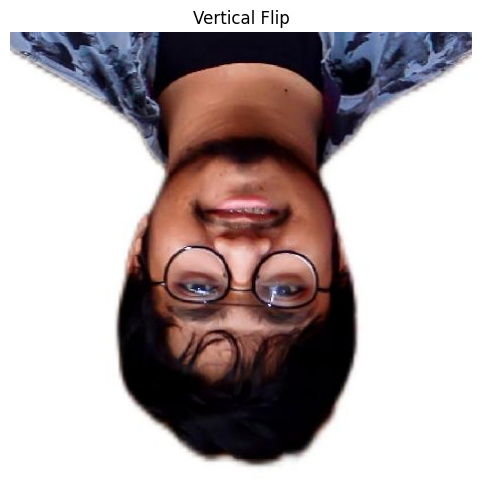

In [39]:
img_b = flip_both(img) # firs perform horizontal flip then vertical flip
show_image(img, "Original")
show_image(img_b, "Both flipped")

img_h = flip_horizontal(img)
show_image(img_h, "Horizontal Flip")

img_v = flip_vertical(img)
show_image(img_v, "Vertical Flip")


# 1️⃣ What is “grayscale” really?

A grayscale image:

- Has **no color**
- Only shows **brightness** (dark → light)

Instead of **3 values per pixel** (R, G, B), you now have **1 value per pixel**.

So:

- RGB image → `(H, W, 3)`
- Grayscale image → `(H, W)`


A color space defines **how color information is represented** in an image.

Common color spaces:
- RGB (Red, Green, Blue)
- Grayscale
- BGR (used by OpenCV)
- HSV (Hue, Saturation, Value)

Each color space is useful for different tasks.

---

## RGB color space (default for most images)

RGB images have **3 channels**:
- Red
- Green
- Blue

Image shape: (height, width, 3)

RGB is:
- Easy to understand
- Used by most ML models
- Used by `matplotlib` for display

---

## Grayscale images

A grayscale image has **only one channel**.

It represents:
- Brightness / intensity
- No color information

Image shape: (height, width)

## 2️⃣ Why grayscale is useful (intuition)

You convert an image to grayscale when:

- Color does **not** matter
- Shape, edges, or texture matter more

Common examples:
- Edge detection
- Text / document images
- Medical scans
- Classical computer vision tasks

Benefits of grayscale:
- Faster processing
- Less memory usage
- Simpler models


## 3️⃣ What happens during RGB → Grayscale conversion?

During RGB → Grayscale conversion:

- The computer looks at the **Red, Green, and Blue** values
- These values are combined into **one brightness value**

Important idea:

> Grayscale is **not just removing color**.  
> It is a **smart combination** of RGB values to represent brightness.

You do **not** need to calculate this yourself —  
image processing libraries handle it for you.


## 4️⃣ OpenCV vs image loading libraries (important beginner note)

Different libraries load images in different color orders.

- `imageio.imread()` and `PIL` load images in **RGB**
- `cv2.imread()` loads images in **BGR**

This difference is very important when converting color spaces.

If you use the wrong conversion, the output grayscale image will look incorrect.

Rule of thumb:
- If image is loaded with **OpenCV** → assume **BGR**
- Otherwise → assume **RGB**

---

## 5️⃣ When NOT to use grayscale (very important)

Do **not** convert an image to grayscale when:

- Color is important for the task
- The class depends on color differences
- You are training color-sensitive CNN models

Examples:
- Traffic lights
- Fruits and vegetables
- Clothes or fashion images
- Any task where color carries meaning

In these cases, keep the image in **RGB**.

---

## 6️⃣ Beginner mental rule (easy to remember)

> If the task depends on **shape, edges, or texture** → use **grayscale**  
> If the task depends on **color information** → keep **RGB**

This simple rule is enough for most beginner ML and CV problems.


In [1]:
def to_grayscale(img, from_bgr=False):
    """
    Convert image to grayscale.

    from_bgr=True if image was read using cv2.imread()
    """
    if from_bgr:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


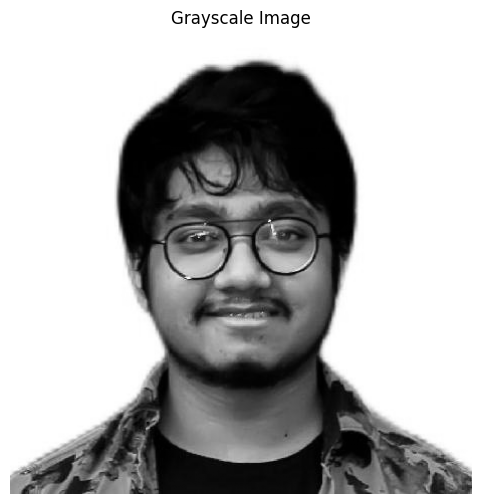

In [8]:
gray = to_grayscale(img)
show_image(gray, "Grayscale Image")


# HSV + Mask + Morphology (Step 1)

## What is HSV?

HSV is a color representation that is often easier than RGB for **color detection**.

HSV = **Hue, Saturation, Value**

- **Hue (H)** = the *color type* (red/green/blue etc.) — think “color wheel”
- **Saturation (S)** = how *strong/pure* the color is  
  - low S → grayish/faded  
  - high S → vivid color
- **Value (V)** = how *bright* the color is  
  - low V → dark  
  - high V → bright

---

## Why use HSV instead of RGB?

In RGB, color and brightness are mixed together. If lighting changes, RGB values change a lot.

HSV separates these ideas:
- **Hue** mostly represents *color*
- **Value** represents *brightness*

So HSV makes color-based selection (like “find all blue pixels”) much easier.


# HSV + Mask + Morphology (Step 2)

## Important OpenCV notes

### 1) BGR vs RGB
- `cv2.imread()` loads images as **BGR**
- `imageio.imread()` / PIL usually load images as **RGB**
- `matplotlib` displays images as **RGB**

If you convert with the wrong assumption (RGB vs BGR), results can look wrong.

### 2) Hue range in OpenCV
OpenCV stores HSV as:
- **Hue:** `0–179` (not `0–360`)
- **Saturation:** `0–255`
- **Value:** `0–255`

This is normal — just remember it when choosing ranges.


# HSV + Mask + Morphology (Step 3)

## What is a mask?

A **mask** is a black-and-white image (binary image) where:

- White (255) means: **selected / detected**
- Black (0) means: **not selected**

When you create an HSV mask, you are saying:

> “Select all pixels whose HSV values fall inside a chosen range.”

A mask is usually used to:
- detect a colored object
- segment the image by color
- keep only pixels that match a color


# HSV + Mask + Morphology (Step 4)

## Creating a mask using HSV ranges

To create a mask, you choose a lower and upper HSV limit:

- `lower = (H_min, S_min, V_min)`
- `upper = (H_max, S_max, V_max)`

Then the mask contains:
- white pixels where `lower <= HSV <= upper`
- black pixels everywhere else

### Example idea (blue-ish range)
A common starting range for blue in OpenCV HSV is:
- Hue around `90–130`

You usually also set minimum Saturation and Value so you don’t pick gray/dark noise.


# HSV + Mask + Morphology (Step 5)

## Applying the mask to the image

After you create a mask, you can keep only the detected pixels:

- Pixels where mask is white (255) remain
- Pixels where mask is black (0) become black

This gives you an output like:
- only the blue object remains
- the rest is removed (black background)

This is called **color-based segmentation**.


# HSV + Mask + Morphology (Step 6)

## Why masks look noisy (very common)

Raw HSV masks often contain noise:

- small white dots in the background
- broken objects (gaps)
- holes inside the object

This happens due to:
- lighting changes
- shadows
- reflections
- imperfect color boundaries

So we usually **clean the mask** before using it.


# HSV + Mask + Morphology (Step 7)

## Morphology (mask cleaning)

Morphology is a set of operations that work on **binary images** (masks).

It helps to:
- remove small white noise
- fill small holes
- smooth object boundaries

Think of morphology like using a “brush” on the mask:
- it can shrink, grow, or smooth white regions.


# HSV + Mask + Morphology (Step 8)

## Erosion and Dilation (core operations)

### Erosion (shrink white)
- makes white regions smaller
- removes tiny white dots
- can break thin connections

Mental model:
> “Rub away the edges — small noise disappears.”

### Dilation (grow white)
- makes white regions larger
- fills small gaps and holes
- can connect nearby regions

Mental model:
> “Paint outward — gaps get filled.”


# HSV + Mask + Morphology (Step 9)

## Opening and Closing (most useful combinations)

### Opening = Erosion → Dilation
Use when:
- you want to remove small white noise (dots)

### Closing = Dilation → Erosion
Use when:
- you want to fill small holes/gaps inside the object

These two operations solve most mask-cleaning problems.


# HSV + Mask + Morphology (Step 10)

## Practical workflow (easy to remember)

A common beginner-friendly pipeline is:

1. Convert image to **HSV**
2. Create a **mask** using HSV ranges
3. Clean the mask using **morphology**
   - Opening (remove noise)
   - Closing (fill holes)
4. Apply mask to the original image

Shortcut to remember: HSV → Mask → Clean → Apply


This pipeline is a foundation for:
- classical computer vision
- color-based tracking
- preprocessing before contour detection



## Standard `s_min` and `v_min` values in HSV (Beginner Notes)

There is **no single universal value** for `s_min` and `v_min`, but there are **safe standard defaults** that work well in most cases.

### Common standard starting values
```text
s_min = 80
v_min = 50

```
| Scenario                  | s_min | v_min |
| ------------------------- | ----- | ----- |
| Default / normal lighting | 80    | 50    |
| Colorful background       | 120   | 50    |
| Dark or shadowy image     | 80    | 100   |
| Low light / faded object  | 40    | 30    |
| Clean studio lighting     | 100   | 80    |


In [16]:
def to_hsv(img, from_bgr=False):
    """
    Convert an image to HSV.

    from_bgr=True  -> image loaded with cv2.imread() (BGR)
    from_bgr=False -> image loaded with imageio/PIL (RGB)
    """
    if from_bgr:
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [13]:
def hsv_range_mask(hsv_img, lower, upper):
    """
    Create a binary mask for pixels within [lower, upper] in HSV.
    White (255) means “matched”, black (0) means “not matched”.

    lower/upper: tuples like (H, S, V)
    """
    lower = np.array(lower, dtype=np.uint8)
    upper = np.array(upper, dtype=np.uint8)
    return cv2.inRange(hsv_img, lower, upper)

In [14]:
def apply_mask(img, mask):
    """
    Keep only pixels where mask == 255.
    """
    return cv2.bitwise_and(img, img, mask=mask)

In [21]:
def make_kernel(size=3):
    """
    Create a square kernel for morphology.
    size should be odd: 3, 5, 7...
    """
    return np.ones((size, size), np.uint8)


In [22]:
def remove_noise(mask, kernel_size=3):
    """
    Remove small white noise from a binary mask.
    """
    kernel = make_kernel(kernel_size)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)


In [23]:
def fill_holes(mask, kernel_size=3):
    """
    Fill small black holes inside white regions.
    """
    kernel = make_kernel(kernel_size)
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)


In [24]:
def clean_mask(mask, kernel_size=3):
    """
    Clean a binary mask by removing noise and filling holes.
    """
    mask = remove_noise(mask, kernel_size)
    mask = fill_holes(mask, kernel_size)
    return mask


In [27]:
def red_mask(hsv_img, s_min=80, v_min=50):
    """
    Red wraps around hue=0 in OpenCV HSV (0..179), so we combine two ranges.
    """
    mask1 = hsv_range_mask(hsv_img, (0,   s_min, v_min), (10,  255, 255))
    mask2 = hsv_range_mask(hsv_img, (170, s_min, v_min), (179, 255, 255))
    return cv2.bitwise_or(mask1, mask2)

In [28]:
def blue_mask(hsv_img, s_min=80, v_min=50):
    # Blue approx: H 90..130
    return hsv_range_mask(hsv_img, (90,  s_min, v_min), (130, 255, 255))

In [29]:
def green_mask(hsv_img, s_min=80, v_min=50):
    # Green approx: H 35..85
    return hsv_range_mask(hsv_img, (35,  s_min, v_min), (85,  255, 255))

In [36]:
def detect_color(img, color, from_bgr=False, kernel_size=3, s_min=80, v_min=50):
    """
    color: 'blue' | 'green' | 'red'
    Returns: (raw_mask, cleaned_mask, result_image)
    kernal_size = 3, 5, 7... (define intenstity to detect/remove noise)
    """
    hsv = to_hsv(img, from_bgr=from_bgr)

    if color == "blue":
        raw = blue_mask(hsv, s_min=s_min, v_min=v_min)
    elif color == "green":
        raw = green_mask(hsv, s_min=s_min, v_min=v_min)
    elif color == "red":
        raw = red_mask(hsv, s_min=s_min, v_min=v_min)
    else:
        raise ValueError("color must be one of: 'blue', 'green', 'red'")

    cleaned = clean_mask(raw, kernel_size=kernel_size)
    result = apply_mask(img, cleaned)
    return raw, cleaned, result

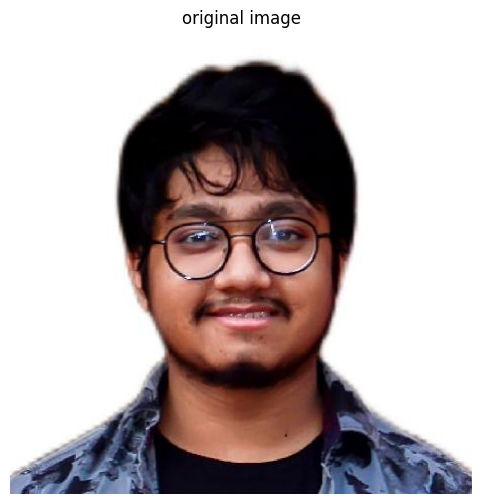

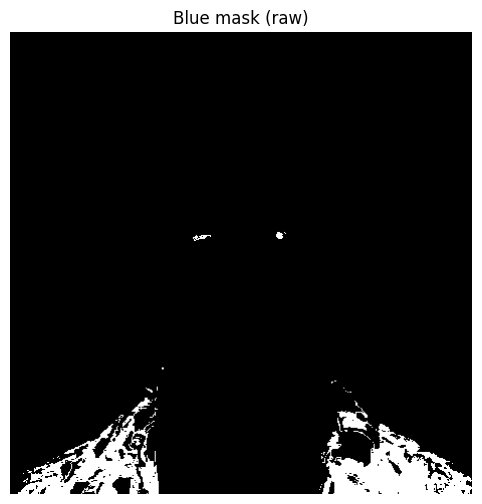

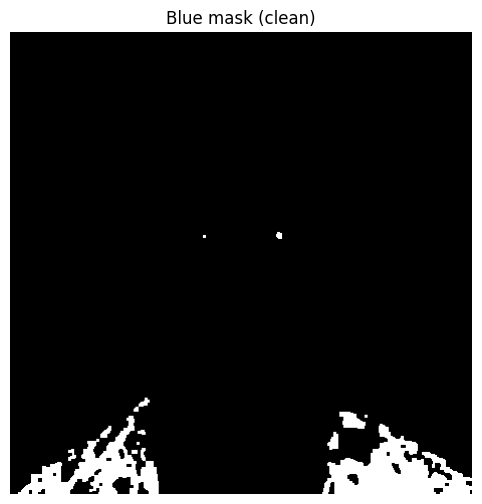

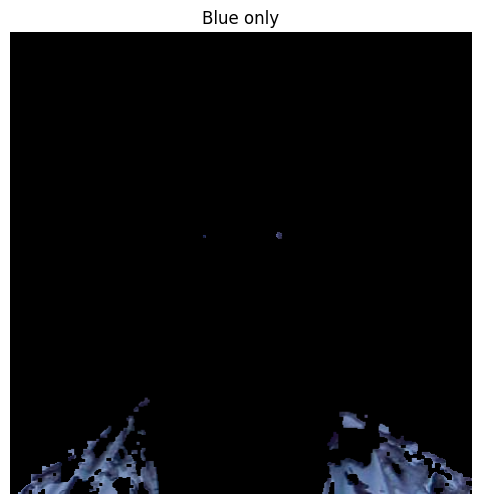

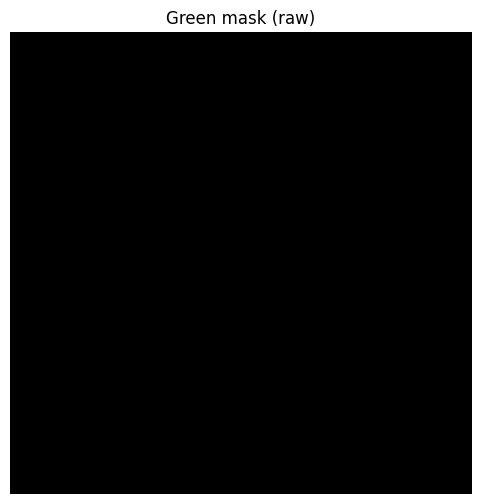

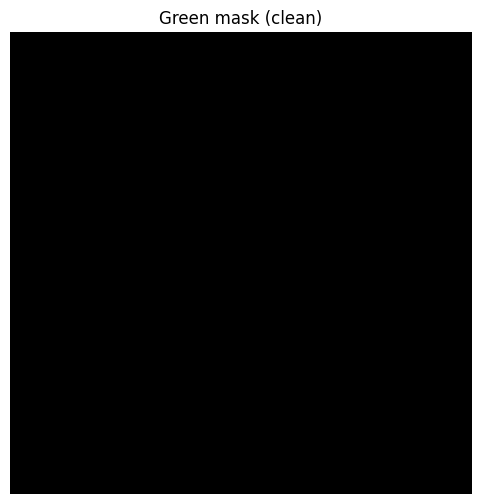

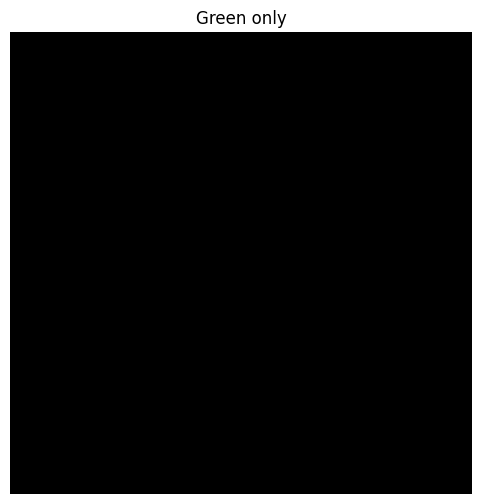

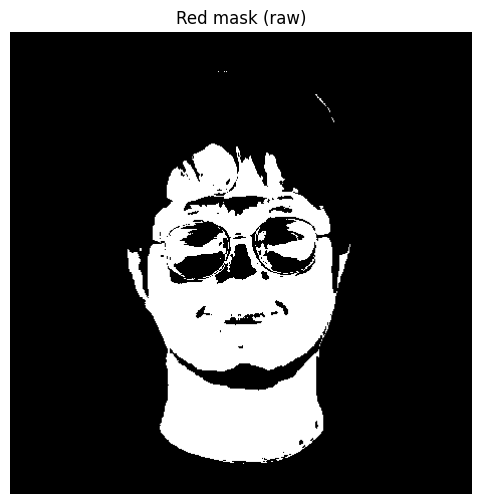

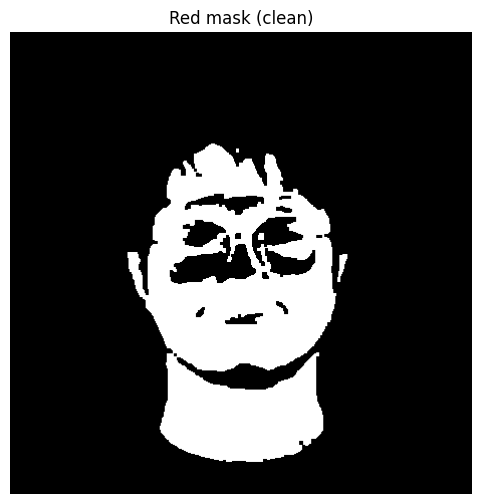

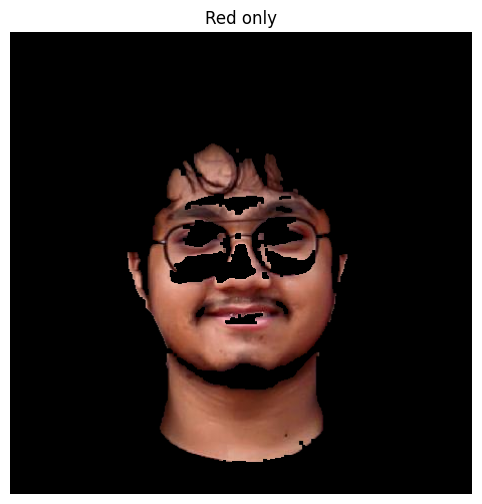

In [37]:
# If img came from imageio/PIL -> from_bgr=False (RGB)
raw_b, clean_b, blue_only = detect_color(img, "blue", from_bgr=False, kernel_size=3)
raw_g, clean_g, green_only = detect_color(img, "green", from_bgr=False, kernel_size=3)
raw_r, clean_r, red_only = detect_color(img, "red", from_bgr=False, kernel_size=3)

show_image(img, "original image")

show_image(raw_b, "Blue mask (raw)")
show_image(clean_b, "Blue mask (clean)")
show_image(blue_only, "Blue only")

show_image(raw_g, "Green mask (raw)")
show_image(clean_g, "Green mask (clean)")
show_image(green_only, "Green only")

show_image(raw_r, "Red mask (raw)")
show_image(clean_r, "Red mask (clean)")
show_image(red_only, "Red only")
